In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "cbs_pc6_2024_v1/pc6_2024_v1.xlsx"

In [3]:
df = pd.read_excel(path, skiprows=6, header=[0, 1])  

In [4]:
print(df.columns.tolist())


[('Unnamed: 0_level_0', 'Unnamed: 0_level_1'), ('Inwoners', 'Totaal'), ('Inwoners', 'Geslacht'), ('Inwoners', 'Geslacht.1'), ('Inwoners', 'Leeftijdklassen'), ('Inwoners', 'Leeftijdklassen.1'), ('Inwoners', 'Leeftijdklassen.2'), ('Inwoners', 'Leeftijdklassen.3'), ('Inwoners', 'Leeftijdklassen.4'), ('Inwoners', 'Geboorten'), ('Inwoners', 'Herkomst'), ('Inwoners', 'Herkomst.1'), ('Inwoners', 'Herkomst.2'), ('Inwoners', 'Herkomst.3'), ('Inwoners', 'Herkomst.4'), ('Huishouden', 'Totaal'), ('Huishouden', 'Samenstelling'), ('Huishouden', 'Samenstelling.1'), ('Huishouden', 'Samenstelling.2'), ('Huishouden', 'Samenstelling.3'), ('Huishouden', 'Grootte'), ('Woning', 'Totaal'), ('Woning', 'Bouwperiode'), ('Woning', 'Bouwperiode.1'), ('Woning', 'Bouwperiode.2'), ('Woning', 'Bouwperiode.3'), ('Woning', 'Bouwperiode.4'), ('Woning', 'Bouwperiode.5'), ('Woning', 'Bouwperiode.6'), ('Woning', 'Bouwperiode.7'), ('Woning', 'Type'), ('Woning', 'Type.1'), ('Woning', 'Eigendom'), ('Woning', 'Eigendom.1'), ('

In [6]:
df = df.rename(columns={
    ('Unnamed: 0_level_0', 'Unnamed: 0_level_1'): 'postcode6',
    ('Huishouden', 'Totaal'): 'total_households',
    ('Huishouden', 'Samenstelling'): 'single',
    ('Huishouden', 'Samenstelling.1'): 'couple_no_kids',
    ('Huishouden', 'Samenstelling.2'): 'single_parent',
    ('Huishouden', 'Samenstelling.3'): 'with_kids',
    ('Energie, gedurende 2022', 'Unnamed: 37_level_1'): 'elek_usage',
    ('Sociale Zekerheid', 'Totaal uitkeringen'): 'vulnerable'
})

columns_needed = ['postcode6', 'total_households', 'single', 'couple_no_kids', 'single_parent', 'with_kids', 'elek_usage', 'vulnerable']
df = df[columns_needed]

df.columns = [col if isinstance(col, str) else col for col in df.columns]

print(df.columns[:10])



Index(['postcode6', 'total_households', 'single', 'couple_no_kids',
       'single_parent', 'with_kids', 'elek_usage', 'vulnerable'],
      dtype='object')


In [7]:
df = df.replace(-99997, pd.NA)
df = df[df["postcode6"].notna()]
df["postcode6"] = df["postcode6"].astype(str).str.replace(r"\s+", "", regex=True).str.upper()

numeric_cols = ["total_households", "single", "couple_no_kids", "single_parent", "with_kids", "elek_usage", "vulnerable"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

df = df[df["total_households"] > 0]

def fill_HHtype(df):
    cols = ["total_households", "single", "couple_no_kids", "single_parent", "with_kids"]
    df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

    for idx, row in df.iterrows():
        known = row[["single", "couple_no_kids", "single_parent", "with_kids"]].dropna()
        sum_known = known.sum()
        total = row["total_households"]

        if pd.notna(total) and sum_known < total:
            missing = total - sum_known
            for col in ["single", "couple_no_kids", "single_parent", "with_kids"]:
                if pd.isna(row[col]):
                    df.at[idx, col] = missing
                    break
        else:
            for col in ["single", "couple_no_kids", "single_parent", "with_kids"]:
                if pd.isna(row[col]):
                    df.at[idx, col] = 0

    df[cols[1:]] = df[cols[1:]].astype("Int64")  

    return df

df = fill_HHtype(df)

df["hh_group"] = pd.cut(df["total_households"], bins=[0, 10, 25, 50, 100, 250, 500, 1000], labels=False)
group_avg = df.groupby("hh_group")["elek_usage"].mean()

# fill missing elek_usage
def fill_elek(row):
    if pd.notna(row["elek_usage"]):
        return row["elek_usage"]
    else:
        group = pd.cut([row["total_households"]], bins=[0, 10, 25, 50, 100, 250, 500, 1000], labels=False)[0]
        return group_avg.get(group, df["elek_usage"].mean())

df["elek_usage"] = df.apply(fill_elek, axis=1)


# group_avg = df.groupby('total_households')['elek_usage'].mean()

# # fill missing elek_usage based on total_households
# def fill_elek(row):
#     if pd.notna(row['elek_usage']):
#         return row['elek_usage']
#     else:
#         return group_avg.get(row['total_households'], df['elek_usage'].mean())

# df['elek_usage'] = df.apply(fill_elek, axis=1)

df[['single', 'couple_no_kids', 'single_parent', 'with_kids', 'vulnerable']] = df[['single', 'couple_no_kids', 'single_parent', 'with_kids', 'vulnerable']].fillna(0)

df.to_csv("cleaned_household_data.csv", index=False)

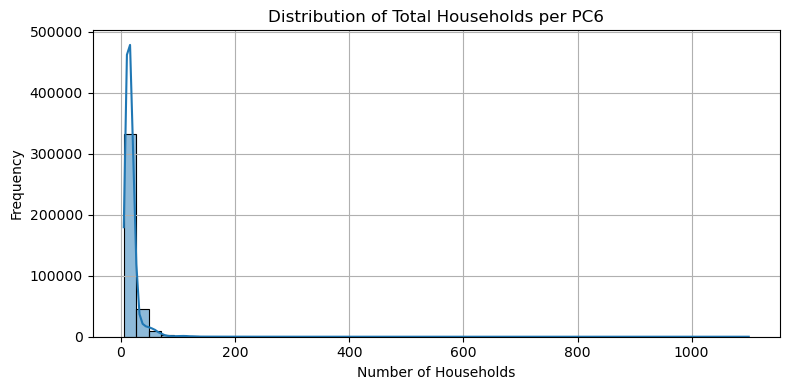

In [8]:
plt.figure(figsize=(8, 4))
sns.histplot(df["total_households"], bins=50, kde=True)
plt.title("Distribution of Total Households per PC6")
plt.xlabel("Number of Households")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


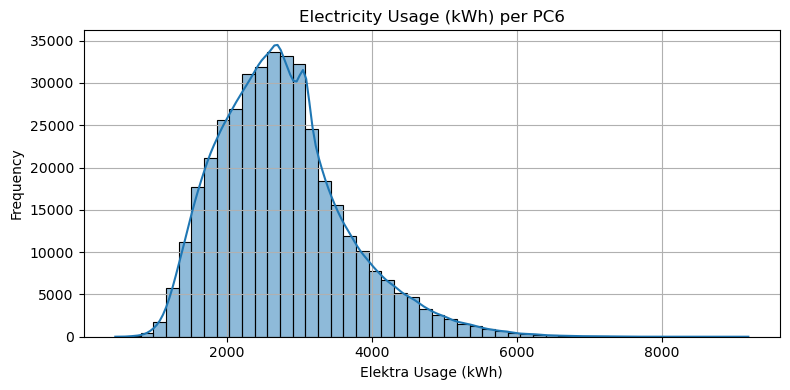

In [9]:
# 
plt.figure(figsize=(8, 4))
sns.histplot(df["elek_usage"], bins=50, kde=True)
plt.title("Electricity Usage (kWh) per PC6")
plt.xlabel("Elektra Usage (kWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

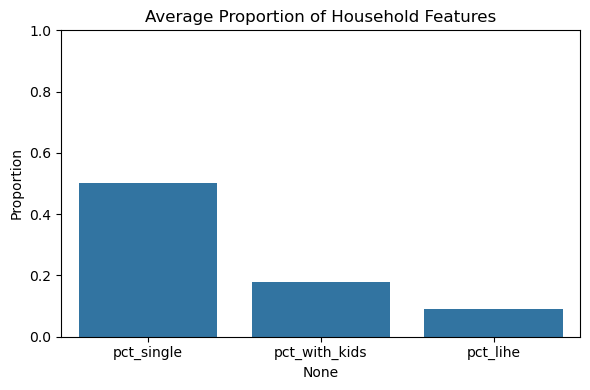

In [10]:
df["pct_single"] = df["single"] / df["total_households"]
df["pct_with_kids"] = df["with_kids"] / df["total_households"]
df["pct_lihe"] = df["vulnerable"] / df["total_households"]

means = df[["pct_single", "pct_with_kids", "pct_lihe"]].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=means.index, y=means.values)
plt.title("Average Proportion of Household Features")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


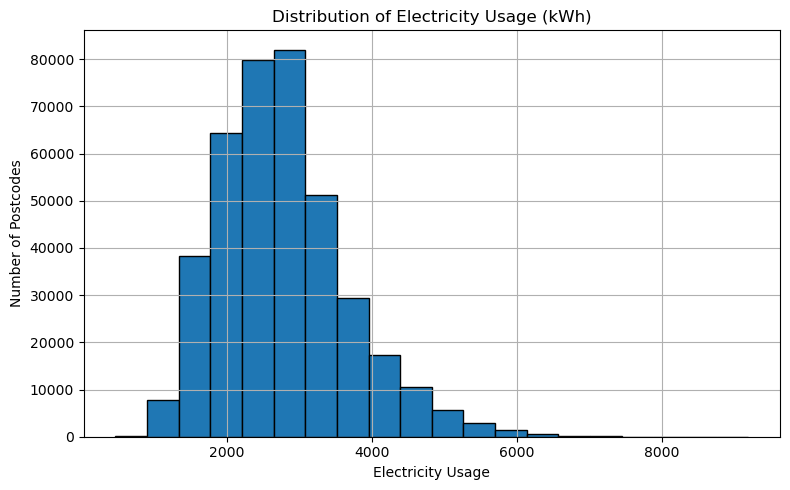

In [11]:
plt.figure(figsize=(8, 5))
df['elek_usage'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Electricity Usage (kWh)')
plt.xlabel('Electricity Usage')
plt.ylabel('Number of Postcodes')
plt.grid(True)
plt.tight_layout()
plt.show()



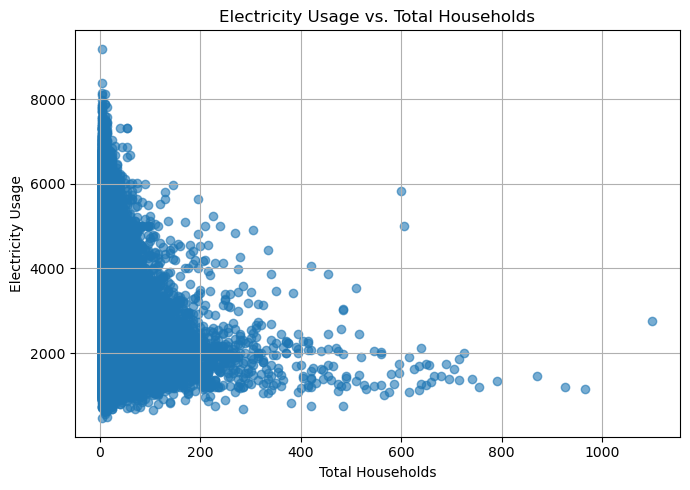

In [12]:

plt.figure(figsize=(7, 5))
plt.scatter(df['total_households'], df['elek_usage'], alpha=0.6)
plt.title('Electricity Usage vs. Total Households')
plt.xlabel('Total Households')
plt.ylabel('Electricity Usage')
plt.grid(True)
plt.tight_layout()
plt.show()


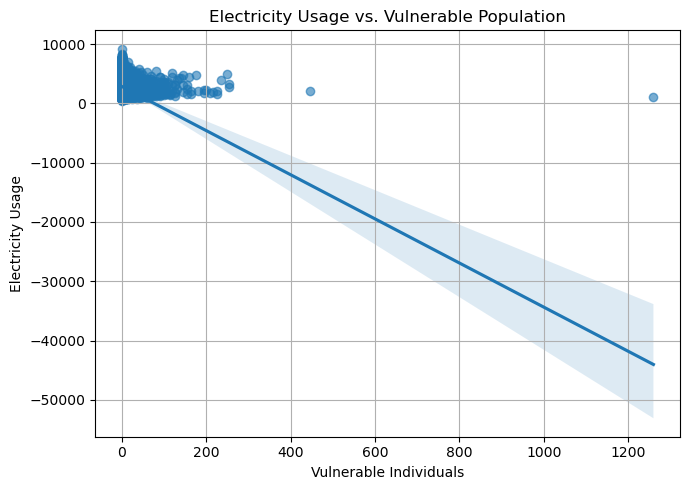

In [13]:

plt.figure(figsize=(7, 5))
sns.regplot(x='vulnerable', y='elek_usage', data=df, scatter_kws={'alpha':0.6})
plt.title('Electricity Usage vs. Vulnerable Population')
plt.xlabel('Vulnerable Individuals')
plt.ylabel('Electricity Usage')
plt.grid(True)
plt.tight_layout()
plt.show()

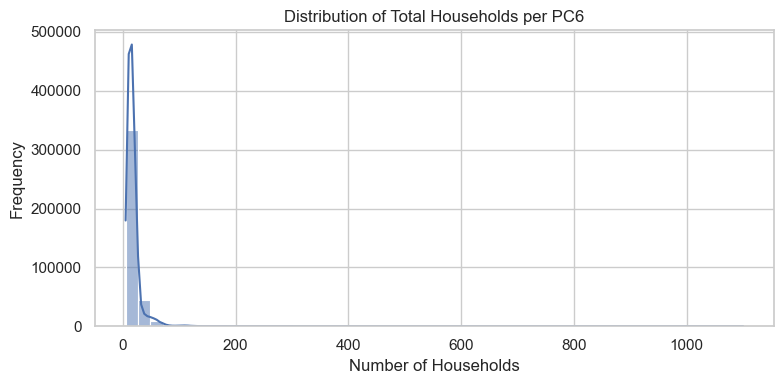

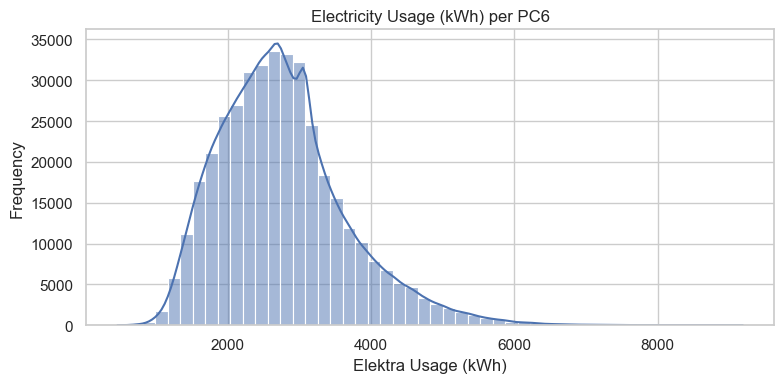

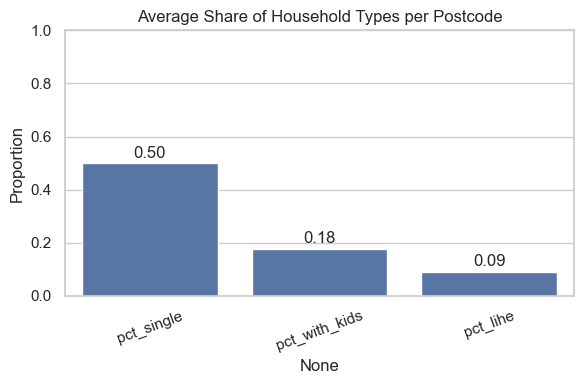

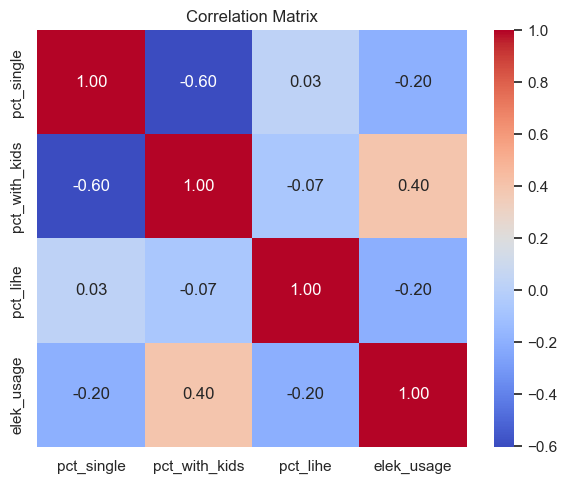

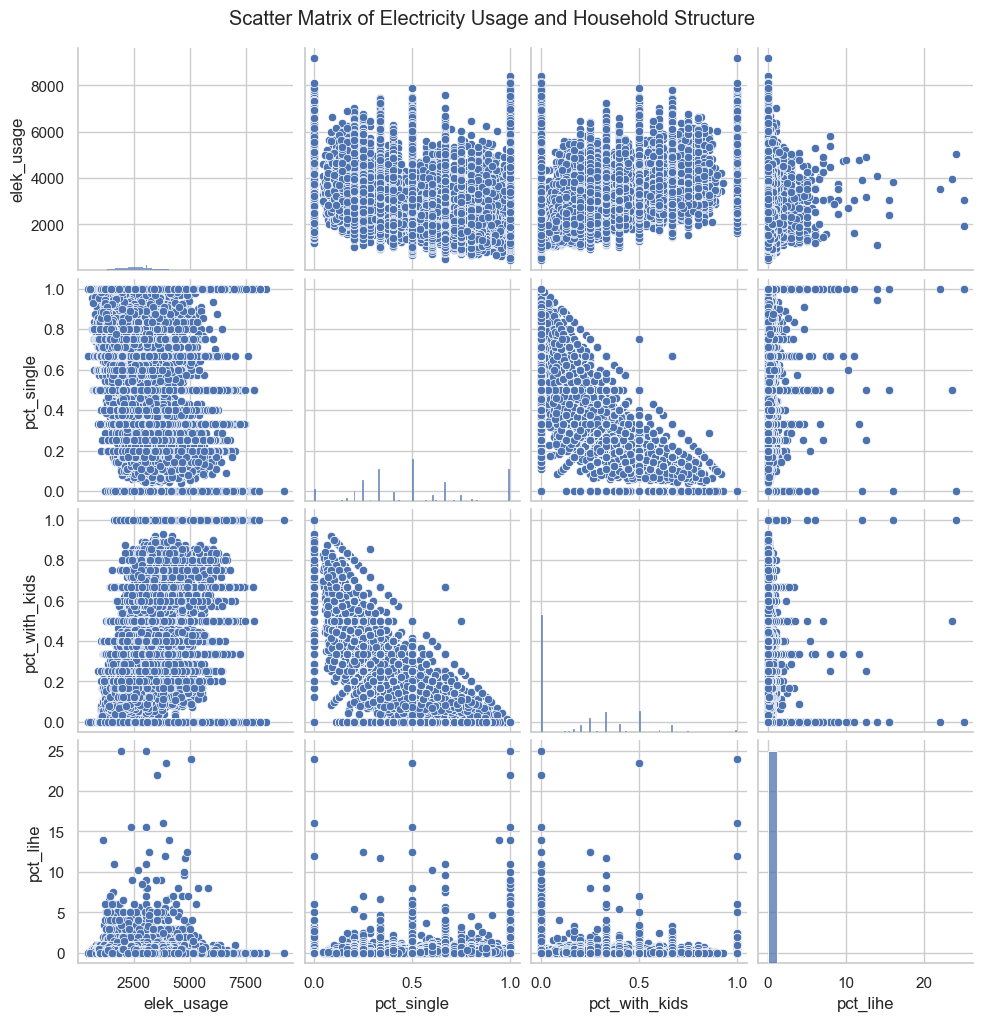

In [14]:
df["pct_single"] = df["single"] / df["total_households"]
df["pct_with_kids"] = df["with_kids"] / df["total_households"]
df["pct_lihe"] = df["vulnerable"] / df["total_households"]

# 设置样式
sns.set(style="whitegrid")

# 图1：户数分布
plt.figure(figsize=(8, 4))
sns.histplot(df["total_households"], bins=50, kde=True)
plt.title("Distribution of Total Households per PC6")
plt.xlabel("Number of Households")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 图2：电力使用分布
plt.figure(figsize=(8, 4))
sns.histplot(df["elek_usage"], bins=50, kde=True)
plt.title("Electricity Usage (kWh) per PC6")
plt.xlabel("Elektra Usage (kWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 图3：不同类型家庭的平均比例
means = df[["pct_single", "pct_with_kids", "pct_lihe"]].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=means.index, y=means.values)
plt.title("Average Share of Household Types per Postcode")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.xticks(rotation=20)
for i, v in enumerate(means.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# 图4：相关性热图
plt.figure(figsize=(6, 5))
sns.heatmap(df[["pct_single", "pct_with_kids", "pct_lihe", "elek_usage"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 图5：变量关系散点图矩阵
sns.pairplot(df[["elek_usage", "pct_single", "pct_with_kids", "pct_lihe"]])
plt.suptitle("Scatter Matrix of Electricity Usage and Household Structure", y=1.02)
plt.show()
